### Load required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Load the data

In [2]:
df = pd.read_csv('./data/creditcard.csv', index_col=0)
print(df.shape)
df.head()

(284807, 30)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,,,,,,,,,,,,,,,,,,,,,
0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Data check

In [3]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [4]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [5]:
df.isnull().values.any()

False

In [6]:
df = df.drop(['Amount'], axis=1)

### Train/test split

In [7]:
frauds = df[df.Class == 1]
#normal = df[df.Class == 0].sample(10000)
normal = df[df.Class == 0]
print("Frauds shape: {}".format(frauds.shape))
print("Normal shape: {}".format(normal.shape))

Frauds shape: (492, 29)
Normal shape: (284315, 29)


In [8]:
data = pd.concat([frauds, normal])
data.shape

(284807, 29)

In [9]:
X_train, X_test = train_test_split(data, test_size=0.3, random_state=42)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

X_test, y_test = X_test.drop(['Class'], axis=1).values, X_test['Class'].values

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (199013, 28)
X_test shape: (85443, 28)


### Visualize the data with TSNE and PCA

In [66]:
x1 = df[df.Class == 1]
x2 = df[df.Class == 0].sample(10000)

dfd = x1.append(x2)
x = dfd.drop(['Class'], axis=1)
y = dfd['Class'].values

SEED = 42

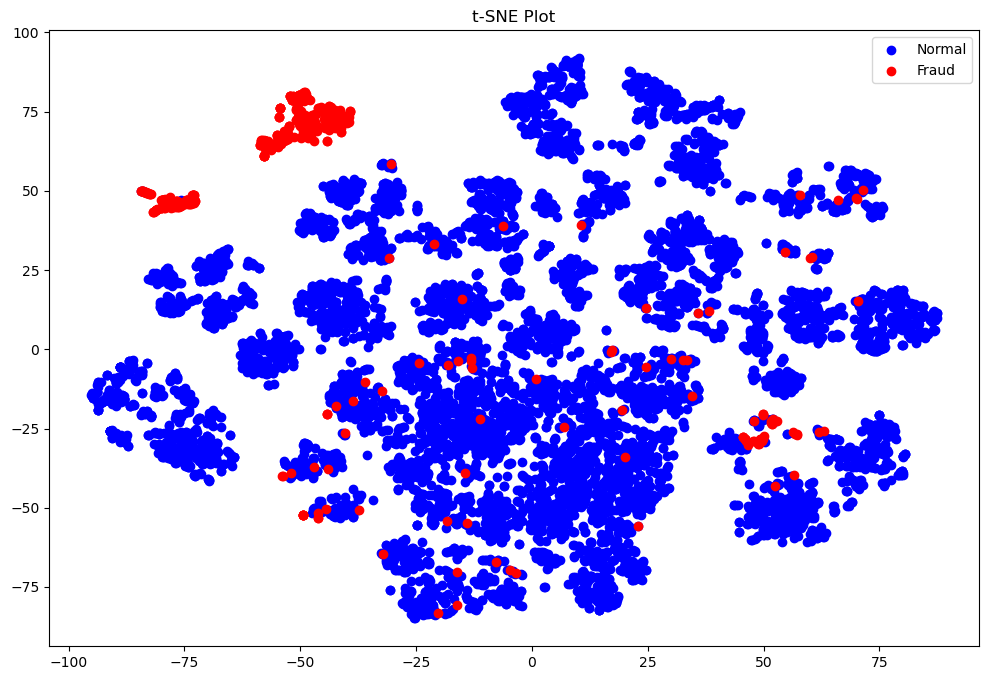

In [67]:
tsne = TSNE(n_components=2, random_state=SEED, init='random', learning_rate=200)
xtsne = tsne.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(xtsne[np.where(y==0), 0], y=xtsne[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xtsne[np.where(y==1), 0], y=xtsne[np.where(y==1), 1], color="red", label='Fraud')
plt.title('t-SNE Plot')
plt.legend()
plt.show()

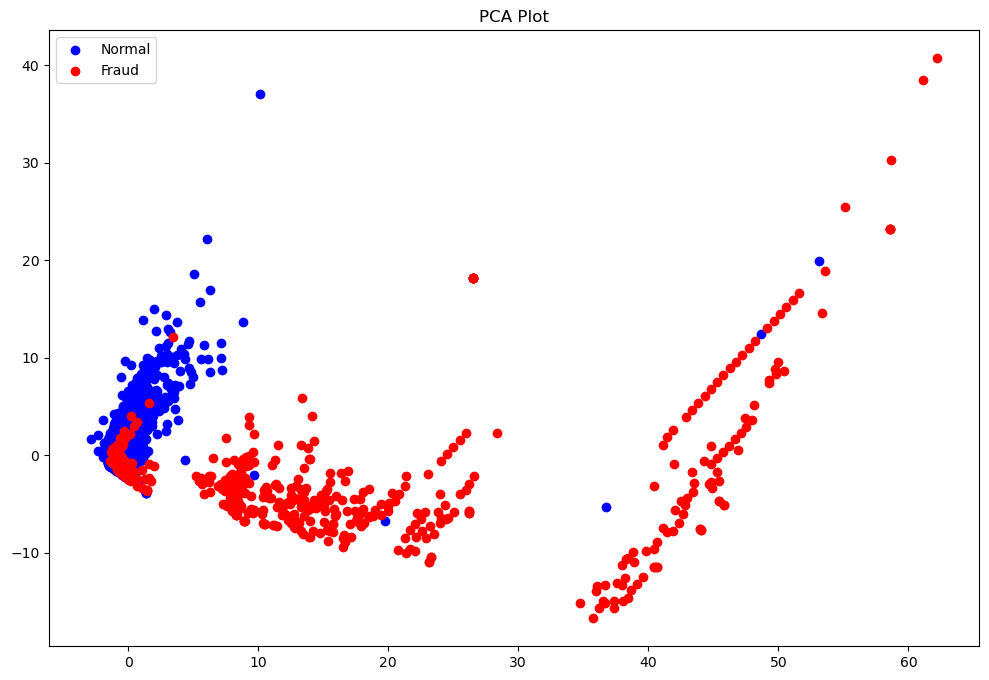

In [68]:
pca = PCA(n_components=2, random_state=SEED)
xpca = pca.fit_transform(x)
plt.figure(figsize=(12,8));
plt.scatter(x=xpca[np.where(y==0), 0], y=xpca[np.where(y==0), 1], color="blue", label='Normal')
plt.scatter(x=xpca[np.where(y==1), 0], y=xpca[np.where(y==1), 1], color="red", label='Fraud')
plt.title('PCA Plot')
plt.legend()
plt.show()

#### Normalize the data

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit_transform(X_train);
scaler.transform(X_test);

### Sparse AutoEncoder Model(L1)

In [11]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(40, activation="elu",activity_regularizer=regularizers.l1(10e-5))(input_layer)

encoder = Dense(56, activation="elu",activity_regularizer=regularizers.l1(10e-5))(encoder)

decoder = Dense(40, activation='elu',activity_regularizer=regularizers.l1(10e-5))(encoder)
decoder = Dense(input_dim, activation='elu')(decoder)
sae_L1 = Model(inputs=input_layer, outputs=decoder)

In [13]:
epochs = 100
batch_size = 32
sae_L1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="/pth/fraudSpAE_L1.h5", verbose=0, save_best_only=True)

### Training

In [14]:
history = sae_L1.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer]).history

Epoch 1/100
5598/5598 [==============================] - 20s 3ms/step - loss: 0.2930 - accuracy: 0.8874 - val_loss: 0.2391 - val_accuracy: 0.9312
Epoch 2/100
5598/5598 [==============================] - 16s 3ms/step - loss: 0.2628 - accuracy: 0.9198 - val_loss: 0.2390 - val_accuracy: 0.9080
Epoch 3/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2591 - accuracy: 0.9201 - val_loss: 0.2329 - val_accuracy: 0.9265
Epoch 4/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2560 - accuracy: 0.9213 - val_loss: 0.2312 - val_accuracy: 0.9213
Epoch 5/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2531 - accuracy: 0.9196 - val_loss: 0.2282 - val_accuracy: 0.9217
Epoch 6/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2524 - accuracy: 0.9176 - val_loss: 0.2289 - val_accuracy: 0.9269
Epoch 7/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2510 - accuracy: 0.9204 - val_loss: 0.2260 -

Epoch 57/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.2420 - accuracy: 0.9476 - val_loss: 0.2207 - val_accuracy: 0.9399
Epoch 58/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.2416 - accuracy: 0.9485 - val_loss: 0.2182 - val_accuracy: 0.9498
Epoch 59/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.2422 - accuracy: 0.9468 - val_loss: 0.2191 - val_accuracy: 0.9495
Epoch 60/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2420 - accuracy: 0.9483 - val_loss: 0.2180 - val_accuracy: 0.9550
Epoch 61/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.2428 - accuracy: 0.9476 - val_loss: 0.2231 - val_accuracy: 0.9335
Epoch 62/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.2415 - accuracy: 0.9499 - val_loss: 0.2171 - val_accuracy: 0.9631
Epoch 63/100
5598/5598 [==============================] - 13s 2ms/step - loss: 0.2417 - accuracy: 0.9482 - val_loss: 0

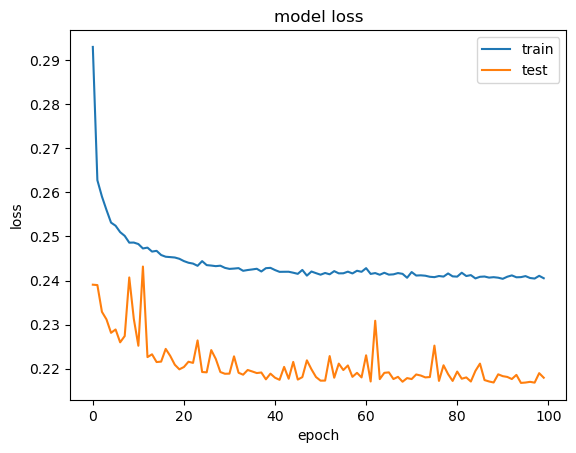

In [15]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [16]:
sae_L1 = load_model('/pth/fraudSpAE_L1.h5')

In [17]:
predictions = sae_L1.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

2671/2671 [==============================] - 4s 1ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.258014,0.00165
std,2.945416,0.04059
min,0.000261,0.00000
25%,0.004938,0.00000
50%,0.028344,0.00000
75%,0.092448,0.00000
max,338.632906,1.00000


In [18]:
threshold = 2.9

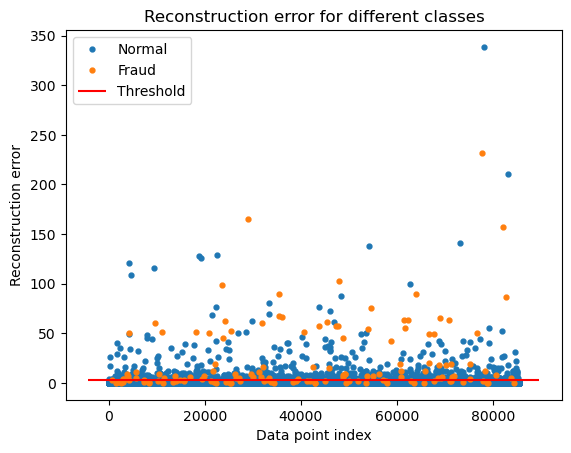

In [19]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

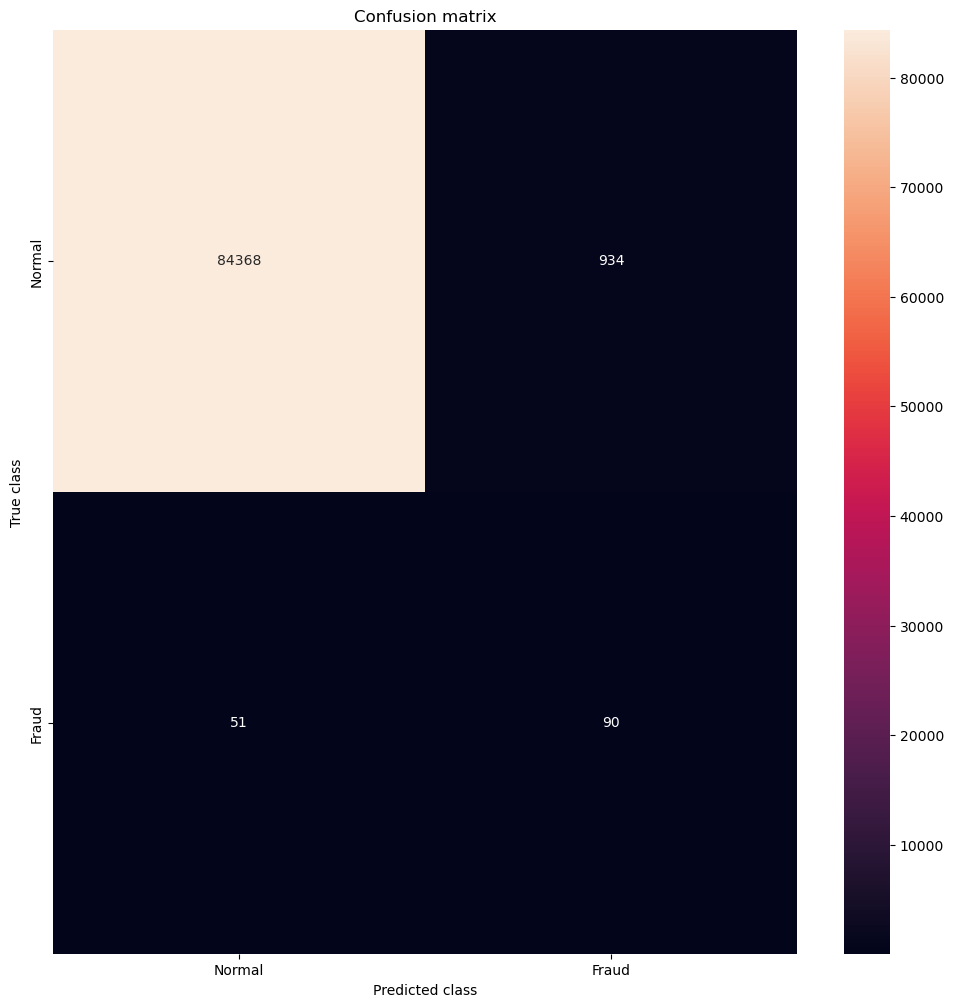

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ['Normal','Fraud']

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Visualize the latent space

In [21]:
inp_layer = sae_L1.input
out_layer = sae_L1.layers[2].output

L1_encoder = Model(inputs=inp_layer, outputs=out_layer)

In [22]:
L1_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 40)                1160      
                                                                 
 dense_1 (Dense)             (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2671/2671 [==============================] - 3s 1ms/step


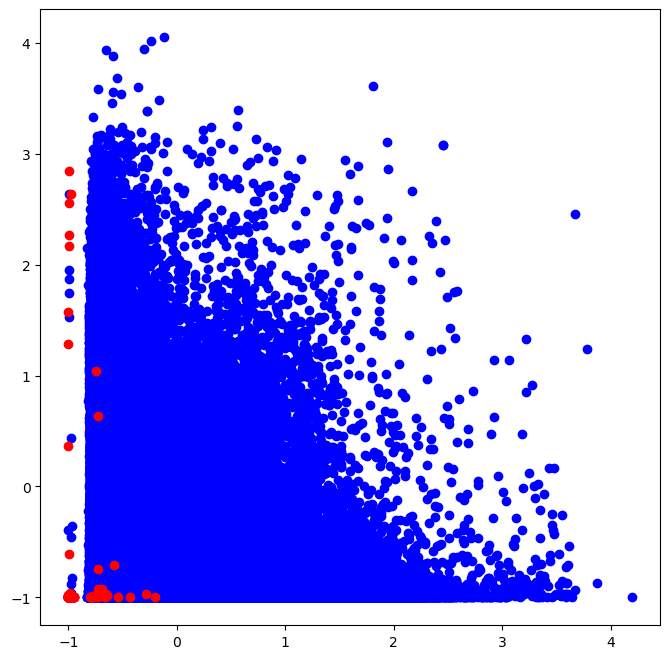

In [24]:
# hidden layer의 units가 많기 때문에 일단 0, 1번째에 대해서 latent space를 구해본다.

X_train_encoded = L1_encoder.predict(X_train)
X_test_encoded = L1_encoder.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = L1_encoder.layers[-1].units;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][0],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');

### Sparse AutoEncoder Model(KL Reg)

In [25]:
input_dim1 = X_train.shape[1]

input_layer1 = Input(shape=(input_dim1, ))
encoder1 = Dense(40, activation="relu")(input_layer1)

encoder1 = Dense(56, activation="relu")(encoder1)

decoder1 = Dense(40, activation='relu')(encoder1)
decoder1 = Dense(input_dim1, activation='relu')(decoder1)

sae_KL = Model(inputs=input_layer1, outputs=decoder1)

#### Def sparse_regularizer

In [26]:
from keras import backend as K
from keras.losses import mse, kld


# def kl_divergence(rho, rho_hat):
#     rho_hat = K.mean(K.sigmoid(rho_hat), axis=1)
#     rho = K.constant([rho] * K.shape(rho_hat)[0])
#     return K.sum(rho * K.log(rho / rho_hat) + (1 - rho) * K.log((1 - rho) / (1 - rho_hat)))

# def sparse_loss(rho, data):
#     values = data
#     loss = 0
#     for layer in autoencoder1.layers:
#         values = layer(values)
#         loss += kl_divergence(rho, values)
#     return loss

def custom_loss(y_true, y_pred):
    mse_loss = mse(y_true, y_pred);
    sparsity = kld(y_true, y_pred);
    beta = 0.001
    
    loss = mse_loss + beta*sparsity
    return loss;

In [27]:
epochs = 100
batch_size = 32

sae_KL.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])
checkpointer1 = ModelCheckpoint(filepath="./path/fraudSpAE_KL.pth", verbose=0, save_best_only=True)

### Training

In [28]:
history1 = sae_KL.fit(X_train, X_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=[checkpointer1]).history

Epoch 1/100
5588/5598 [============================>.] - ETA: 0s - loss: 0.6900 - accuracy: 0.7676INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 15s 2ms/step - loss: 0.6897 - accuracy: 0.7677 - val_loss: 0.6014 - val_accuracy: 0.8547
Epoch 2/100
5586/5598 [============================>.] - ETA: 0s - loss: 0.6314 - accuracy: 0.8427INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6310 - accuracy: 0.8428 - val_loss: 0.5849 - val_accuracy: 0.8993
Epoch 3/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.6234 - accuracy: 0.8633INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 17s 3ms/step - loss: 0.6233 - accuracy: 0.8633 - val_loss: 0.5841 - val_accuracy: 0.8989
Epoch 4/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.6045 - accuracy: 0.9130INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 20s 4ms/step - loss: 0.6050 - accuracy: 0.9130 - val_loss: 0.5796 - val_accuracy: 0.8876
Epoch 5/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6107 - accuracy: 0.8900 - val_loss: 1.1835 - val_accuracy: 0.0628
Epoch 6/100
5596/5598 [============================>.] - ETA: 0s - loss: 0.5974 - accuracy: 0.9212INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 12s 2ms/step - loss: 0.5974 - accuracy: 0.9212 - val_loss: 0.5791 - val_accuracy: 0.8864
Epoch 7/100
5597/5598 [============================>.] - ETA: 0s - loss: 0.6014 - accuracy: 0.9201INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 12s 2ms/step - loss: 0.6014 - accuracy: 0.9201 - val_loss: 0.5672 - val_accuracy: 0.9601
Epoch 8/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6103 - accuracy: 0.8980 - val_loss: 0.5726 - val_accuracy: 0.9256
Epoch 9/100
5592/5598 [============================>.] - ETA: 0s - loss: 0.6097 - accuracy: 0.8952INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 14s 2ms/step - loss: 0.6096 - accuracy: 0.8953 - val_loss: 0.5671 - val_accuracy: 0.9407
Epoch 10/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6150 - accuracy: 0.8929 - val_loss: 0.5712 - val_accuracy: 0.9311
Epoch 11/100
5587/5598 [============================>.] - ETA: 0s - loss: 0.5943 - accuracy: 0.9357INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.5940 - accuracy: 0.9358 - val_loss: 0.5650 - val_accuracy: 0.9643
Epoch 12/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6059 - accuracy: 0.9061 - val_loss: 0.5899 - val_accuracy: 0.8505
Epoch 13/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5991 - accuracy: 0.9237 - val_loss: 0.5666 - val_accuracy: 0.9501
Epoch 14/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6004 - accuracy: 0.9185 - val_loss: 0.5656 - val_accuracy: 0.9504
Epoch 15/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5994 - accuracy: 0.9218 - val_loss: 0.5728 - val_accuracy: 0.9484
Epoch 16/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6092 - accuracy: 0.8953 - val_loss: 0.5786 - val_accuracy: 0.8847
Epoch 17/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6000 - accuracy: 0.9111 - val_loss: 0.5719 - val_a

INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.5968 - accuracy: 0.9330 - val_loss: 0.5647 - val_accuracy: 0.9646
Epoch 22/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5956 - accuracy: 0.9358 - val_loss: 0.5739 - val_accuracy: 0.8973
Epoch 23/100
5595/5598 [============================>.] - ETA: 0s - loss: 0.5940 - accuracy: 0.9420INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 12s 2ms/step - loss: 0.5941 - accuracy: 0.9420 - val_loss: 0.5644 - val_accuracy: 0.9698
Epoch 24/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.6016 - accuracy: 0.9310 - val_loss: 0.5666 - val_accuracy: 0.9515
Epoch 25/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5930 - accuracy: 0.9382 - val_loss: 0.5652 - val_accuracy: 0.9639
Epoch 26/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5936 - accuracy: 0.9407 - val_loss: 0.5680 - val_accuracy: 0.9576
Epoch 27/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5942 - accuracy: 0.9342 - val_loss: 0.5659 - val_accuracy: 0.9406
Epoch 28/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5912 - accuracy: 0.9517 - val_loss: 0.5811 - val_accuracy: 0.9166
Epoch 29/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5935 - accuracy: 0.9496 - val_loss: 0.5717 - val_a

INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.5900 - accuracy: 0.9551 - val_loss: 0.5641 - val_accuracy: 0.9744
Epoch 38/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5905 - accuracy: 0.9486 - val_loss: 0.5651 - val_accuracy: 0.9617
Epoch 39/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5943 - accuracy: 0.9383 - val_loss: 0.5668 - val_accuracy: 0.9397
Epoch 40/100
5598/5598 [==============================] - 11s 2ms/step - loss: 0.5923 - accuracy: 0.9401 - val_loss: 0.5645 - val_accuracy: 0.9636
Epoch 41/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5933 - accuracy: 0.9441 - val_loss: 0.5720 - val_accuracy: 0.9201
Epoch 42/100
5598/5598 [==============================] - 11s 2ms/step - loss: 0.5923 - accuracy: 0.9466 - val_loss: 0.5647 - val_accuracy: 0.9627
Epoch 43/100
5598/5598 [==============================] - 11s 2ms/step - loss: 0.5901 - accuracy: 0.9554 - val_loss: 0.5647 - val_a

INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 12s 2ms/step - loss: 0.5894 - accuracy: 0.9575 - val_loss: 0.5640 - val_accuracy: 0.9763
Epoch 48/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5911 - accuracy: 0.9485 - val_loss: 0.5662 - val_accuracy: 0.9510
Epoch 49/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5904 - accuracy: 0.9518 - val_loss: 0.5640 - val_accuracy: 0.9751
Epoch 50/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5922 - accuracy: 0.9456 - val_loss: 0.5776 - val_accuracy: 0.9107
Epoch 51/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5893 - accuracy: 0.9580 - val_loss: 0.5654 - val_accuracy: 0.9506
Epoch 52/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5901 - accuracy: 0.9548 - val_loss: 0.5704 - val_accuracy: 0.9307
Epoch 53/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5900 - accuracy: 0.9547 - val_loss: 0.5651 - val_a

INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.5895 - accuracy: 0.9579 - val_loss: 0.5639 - val_accuracy: 0.9753
Epoch 57/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5913 - accuracy: 0.9508 - val_loss: 0.5646 - val_accuracy: 0.9685
Epoch 58/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5928 - accuracy: 0.9468 - val_loss: 0.5659 - val_accuracy: 0.9418
Epoch 59/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5912 - accuracy: 0.9547 - val_loss: 0.5667 - val_accuracy: 0.9447
Epoch 60/100
5598/5598 [==============================] - 15s 3ms/step - loss: 0.5914 - accuracy: 0.9495 - val_loss: 0.5648 - val_accuracy: 0.9615
Epoch 61/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5941 - accuracy: 0.9372 - val_loss: 0.5643 - val_accuracy: 0.9635
Epoch 62/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5905 - accuracy: 0.9535 - val_loss: 0.5673 - val_a

INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 18s 3ms/step - loss: 0.5891 - accuracy: 0.9599 - val_loss: 0.5638 - val_accuracy: 0.9820
Epoch 70/100
5598/5598 [==============================] - 19s 3ms/step - loss: 0.5893 - accuracy: 0.9611 - val_loss: 0.5665 - val_accuracy: 0.9433
Epoch 71/100
5598/5598 [==============================] - 17s 3ms/step - loss: 0.5899 - accuracy: 0.9582 - val_loss: 0.5681 - val_accuracy: 0.9438
Epoch 72/100
5598/5598 [==============================] - 18s 3ms/step - loss: 0.5913 - accuracy: 0.9502 - val_loss: 0.5681 - val_accuracy: 0.9236
Epoch 73/100
5598/5598 [==============================] - 21s 4ms/step - loss: 0.5900 - accuracy: 0.9587 - val_loss: 0.5644 - val_accuracy: 0.9677
Epoch 74/100
5598/5598 [==============================] - 24s 4ms/step - loss: 0.5921 - accuracy: 0.9458 - val_loss: 0.5644 - val_accuracy: 0.9676
Epoch 75/100
5598/5598 [==============================] - 22s 4ms/step - loss: 0.5888 - accuracy: 0.9635 - val_loss: 0.5645 - val_a

INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 12s 2ms/step - loss: 0.5903 - accuracy: 0.9481 - val_loss: 0.5635 - val_accuracy: 0.9654
Epoch 99/100
5598/5598 [==============================] - 12s 2ms/step - loss: 0.5897 - accuracy: 0.9550 - val_loss: 0.5652 - val_accuracy: 0.9513
Epoch 100/100
5578/5598 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.9599INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


INFO:tensorflow:Assets written to: ./path\fraudSpAE_KL.pth\assets


5598/5598 [==============================] - 13s 2ms/step - loss: 0.5877 - accuracy: 0.9599 - val_loss: 0.5608 - val_accuracy: 0.9757


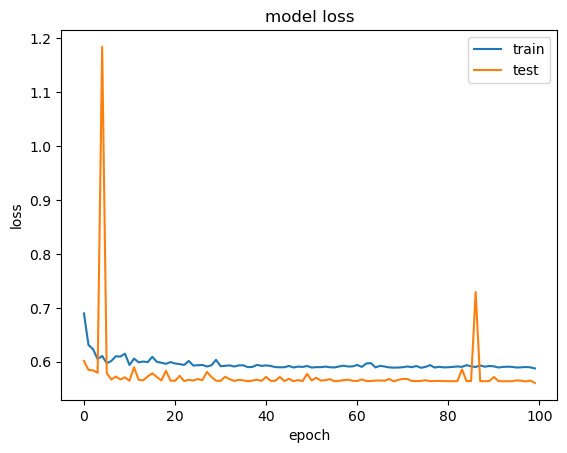

In [29]:
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Test

In [30]:
with keras.utils.custom_object_scope({"custom_loss": 'mse'}):
    sae_KL = keras.models.load_model('./path/fraudSpAE_KL.pth')

In [31]:
KL_encode = sae_KL.predict(X_test)
mse1 = np.mean(np.power(X_test - KL_encode, 2), axis=1)
error_df1 = pd.DataFrame({'reconstruction_error': mse1,
                        'true_class': y_test})
error_df1.describe()

2671/2671 [==============================] - 4s 1ms/step


,reconstruction_error,true_class
count,85443.000000,85443.00000
mean,0.610250,0.00165
std,3.347603,0.04059
min,0.017297,0.00000
25%,0.170886,0.00000
50%,0.294732,0.00000
75%,0.498761,0.00000
max,357.694426,1.00000


In [32]:
threshold1 = 2.9

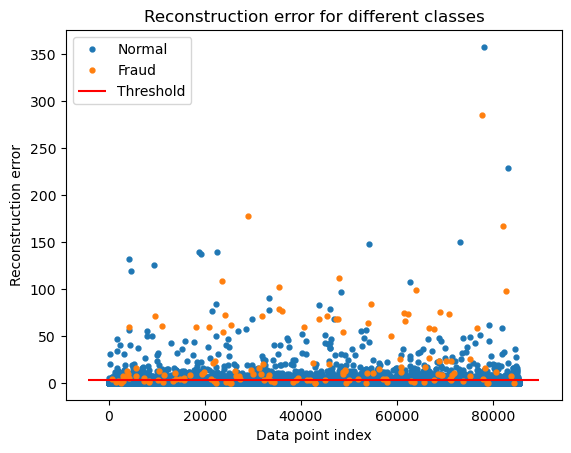

In [33]:
groups = error_df1.groupby('true_class')
fig1, ax1 = plt.subplots()

for name, group in groups:
    ax1.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax1.hlines(threshold1, ax1.get_xlim()[0], ax1.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax1.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

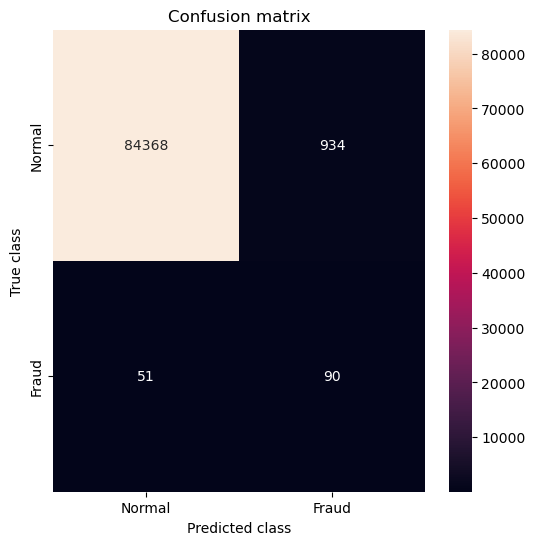

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
LABELS = ["Normal", "Fraud"]

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [39]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
precision, recall, f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')
print ('Accuracy Score :',accuracy_score(error_df.true_class, y_pred) )
print ('Precision :',precision )
print ('Recall :',recall )
print ('F1 :',f1 )

Accuracy Score : 0.9884718467282282
Precision : 0.087890625
Recall : 0.6382978723404256
F1 : 0.15450643776824033


### Visualize the latent space

In [35]:
inp_layer1 = sae_KL.input
out_layer1 = sae_KL.layers[2].output

KL_encoder = Model(inputs=inp_layer1, outputs=out_layer1)

In [36]:
KL_encoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_4 (Dense)             (None, 40)                1160      
                                                                 
 dense_5 (Dense)             (None, 56)                2296      
                                                                 
Total params: 3456 (13.50 KB)
Trainable params: 3456 (13.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2671/2671 [==============================] - 4s 1ms/step


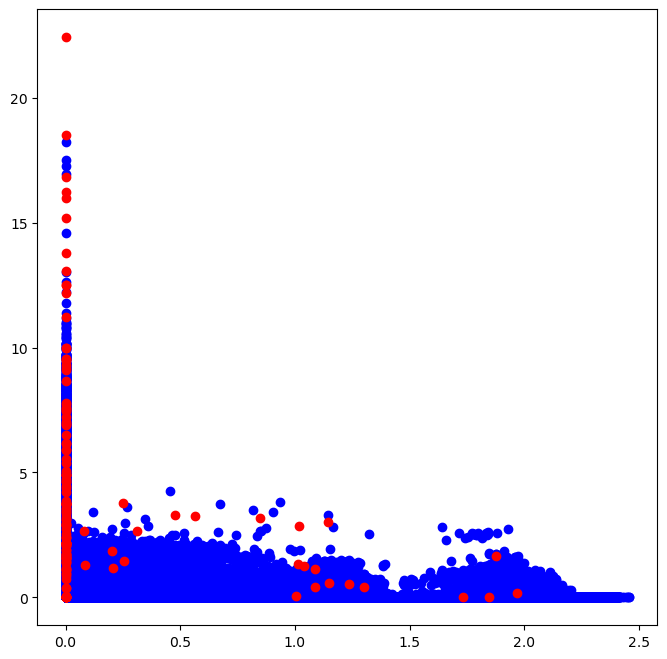

In [37]:
X_train_encoded = sae_KL.predict(X_train)
X_test_encoded = sae_KL.predict(X_test)

X_encoded = np.vstack((X_train_encoded, X_test_encoded))
y_main = np.hstack((np.zeros(len(X_train)), y_test))

encoded_df = pd.DataFrame(np.hstack((X_encoded, y_main[np.newaxis].transpose())))

label = 28;

plt.subplots(figsize=(8,8))
plt.scatter(encoded_df[encoded_df[label]==0][0],encoded_df[encoded_df[label]==0][1], color='blue', label='Normal')
plt.scatter(encoded_df[encoded_df[label]==1][0],encoded_df[encoded_df[label]==1][1], color='red', label='Fraud');